In [1]:

import numpy as np
import torch
import deeplay as dl
import torchvision
import PIL
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import sklearn 
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
import os



In [3]:

def read_mnist_txt(file_path):
    """Read MNIST-like data from text file"""
    images = []
    labels = []
    
    with open(file_path, 'r') as file:
        for line in file:
            if not line.strip():
                continue
            parts = line.strip().split()
            image_num = parts[0].strip('"')
            label = int(parts[1])
            
            # Validate label range
            if label < -9 or label > 9:
                raise ValueError(f"Invalid label {label} found in the dataset.")
            
            pixels = list(map(float, parts[2:]))
            pixel_array = np.array(pixels).reshape(16, 16)
            images.append(pixel_array)
            labels.append(label)
    
    return np.array(images), np.array(labels)

In [4]:
# "Training" function for k-NN (just returns training data and labels)
def train_knn_model(train_images, train_labels, k=3, norm=2):
    return {
        'train_images': train_images,
        'train_labels': train_labels,
        'k': k,
        'norm': norm
    }

# Prediction function for k-NN
def predict_knn(model, test_images):
    train_images = model['train_images']
    train_labels = model['train_labels']
    k = model['k']
    norm = model['norm']
    
    predictions = []
    for image in test_images:
        distances = [(
            np.linalg.norm(train_image - image, ord=norm), label
        ) for train_image, label in zip(train_images, train_labels)]
        
        neighbors = sorted(distances, key=lambda x: x[0])[:k]
        labels = [label for _, label in neighbors]
        predicted = max(labels, key=labels.count)
        predictions.append(predicted)
    
    return predictions


In [5]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def cross_validate(random_state, images, labels, train_fn, predict_fn, k_folds=5, metric_fn=accuracy_score):
    """
    Generic cross-validation.

    Args:
        images (np.ndarray): Image data.
        labels (np.ndarray): Corresponding labels.
        train_fn (callable): Function to train a model. Signature: (train_images, train_labels) -> model
        predict_fn (callable): Function to predict. Signature: (model, test_images) -> predictions
        k_folds (int): Number of folds (default 5).
        metric_fn (callable): Evaluation metric function. Signature: (true_labels, predicted_labels) -> float

    Returns:
        List of scores for each fold.
    """
    all_scores = []
    kf = KFold(n_splits=k_folds, shuffle=True, random_state = random_state)

    for fold, (train_idx, val_idx) in enumerate(kf.split(images)):

        train_images, val_images = images[train_idx], images[val_idx]
        train_labels, val_labels = labels[train_idx], labels[val_idx]

        # Train and predict
        model = train_fn(train_images, train_labels)
        predictions = predict_fn(model, val_images)

        # Score
        score = metric_fn(val_labels, predictions)
        print(f"Fold {fold + 1} Score: {score:.4f}")
        all_scores.append(score)

    return all_scores


Starting cross-validation...

Testing k = 1
  Repeat 1/1
Fold 1 Score: 0.9125
Fold 2 Score: 0.9250
Fold 3 Score: 0.9250
Fold 4 Score: 0.9275
Fold 5 Score: 0.9175
Testing k = 3
  Repeat 1/1
Fold 1 Score: 0.9050
Fold 2 Score: 0.9300
Fold 3 Score: 0.9250
Fold 4 Score: 0.9300
Fold 5 Score: 0.9175
Testing k = 5
  Repeat 1/1
Fold 1 Score: 0.8950
Fold 2 Score: 0.9300
Fold 3 Score: 0.9225
Fold 4 Score: 0.9250
Fold 5 Score: 0.9175
Testing k = 7
  Repeat 1/1
Fold 1 Score: 0.8925
Fold 2 Score: 0.9150
Fold 3 Score: 0.9225
Fold 4 Score: 0.9300
Fold 5 Score: 0.9075
Testing k = 10
  Repeat 1/1
Fold 1 Score: 0.8800
Fold 2 Score: 0.9150
Fold 3 Score: 0.9175
Fold 4 Score: 0.9275
Fold 5 Score: 0.9050


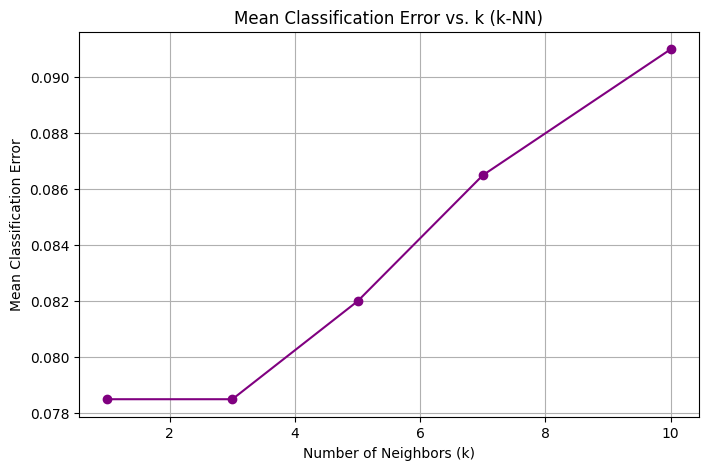


k = 1, Sorted Accuracy Scores (5 values):
[0.9125, 0.9175, 0.925, 0.925, 0.9275]

k = 3, Sorted Accuracy Scores (5 values):
[0.905, 0.9175, 0.925, 0.93, 0.93]

k = 5, Sorted Accuracy Scores (5 values):
[0.895, 0.9175, 0.9225, 0.925, 0.93]

k = 7, Sorted Accuracy Scores (5 values):
[0.8925, 0.9075, 0.915, 0.9225, 0.93]

k = 10, Sorted Accuracy Scores (5 values):
[0.88, 0.905, 0.915, 0.9175, 0.9275]


In [12]:
#tune knn with CV
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from functools import partial

if __name__ == "__main__":
    # Load and preprocess
    images, labels = read_mnist_txt("Numbers.txt")
    flat_images = images.reshape(len(images), -1)
    flat_images = StandardScaler().fit_transform(flat_images)

    # k values to test
    k_values = [1, 3, 5, 7, 10]
    repeats = 1
    all_results = []

    print("Starting cross-validation...\n")

    for k in k_values:
        print(f"Testing k = {k}")
        scores_k = []
        train_fn = partial(train_knn_model, k=k, norm=2)

        for rep in range(repeats):
            print(f"  Repeat {rep + 1}/{repeats}")
            scores = cross_validate(
                random_state=42 + rep,
                images=flat_images,
                labels=labels,
                train_fn=train_fn,
                predict_fn=predict_knn,
                k_folds=5,
                metric_fn=accuracy_score
            )
            scores_k.extend(scores)

        all_results.append(scores_k)

    # Compute mean classification error for each k
knn_mean_errors = [1 - np.mean(scores) for scores in all_results]

plt.figure(figsize=(8, 5))
plt.plot(k_values, knn_mean_errors, marker='o', linestyle='-', color='purple')
plt.title("Mean Classification Error vs. k (k-NN)")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Mean Classification Error")
plt.grid(True)
plt.show()

for i, k in enumerate(k_values):
    sorted_scores = sorted(all_results[i])
    print(f"\nk = {k}, Sorted Accuracy Scores ({len(sorted_scores)} values):")
    print(sorted_scores)


C:\Users\Nils\AppData\Local\Temp\ipykernel_18384\126570759.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(knn_error_results, labels=k_values, showfliers=False)


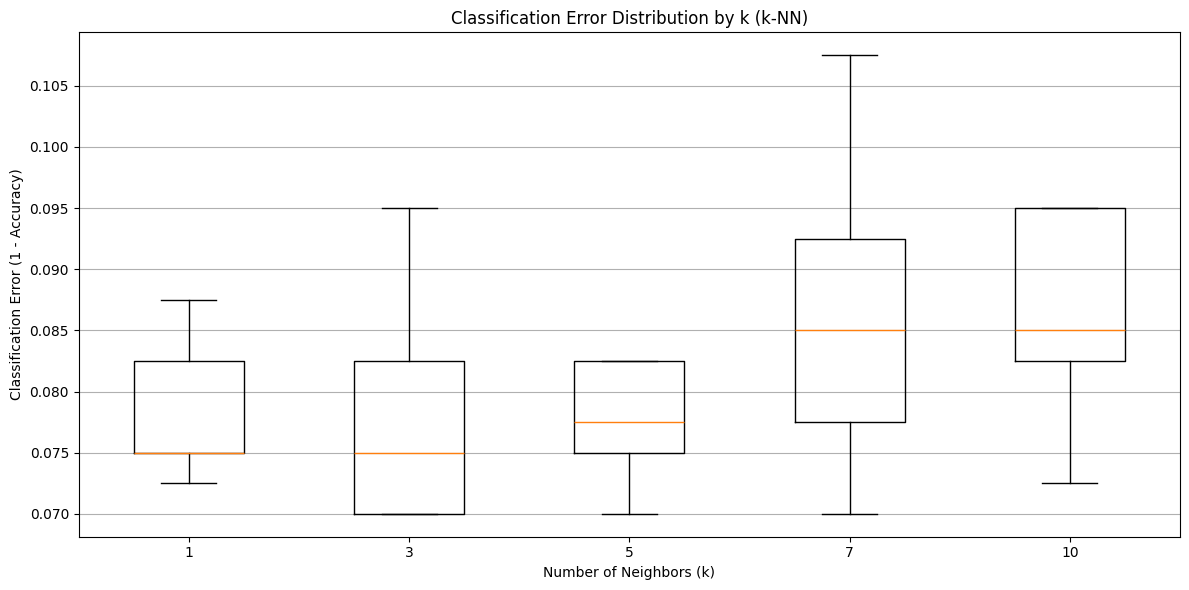

In [13]:
# Convert accuracy scores to errors before plotting the boxplot
knn_error_results = [[1 - score for score in scores] for scores in all_results]

# Plot boxplot for classification error
plt.figure(figsize=(12, 6))
plt.boxplot(knn_error_results, labels=k_values, showfliers=False)
plt.title("Classification Error Distribution by k (k-NN)")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Classification Error (1 - Accuracy)")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()
